In [ ]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 1.13.0+cu116
torchvision version: 0.14.0+cu116


In [ ]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

In [ ]:
# See if torchmetrics exists, if not, install it
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

mlxtend version: 0.21.0


In [ ]:
# Import mlxtend upgraded version
import mlxtend 
print(mlxtend.__version__)
assert int(mlxtend.__version__.split(".")[1]) >= 19 # should be version 0.19.0 or higher

0.21.0


In [ ]:
# The following requires torch v0.12+ and torchvision v0.13+
import torch
import torchvision
print(torch.__version__) 
print(torchvision.__version__)

1.13.0+cu116
0.14.0+cu116


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
from helper_functions import download_data

# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://app.roboflow.com/ds/1SkfKQu9tA?key=ncc1uuLVLL",
                           destination="kematangan_pisang")
image_path

[INFO] data/kematangan_pisang directory exists, skipping download.


PosixPath('data/kematangan_pisang')

In [ ]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

In [ ]:
# Create image size (from Table 3 in the ViT paper) 
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])           
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
)


In [ ]:
  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=ToTensor())
  test_data = datasets.ImageFolder(test_dir, transform=ToTensor())

In [ ]:
# Set the batch size
BATCH_SIZE = 32 # this is lower than the ViT paper but it's because we're starting small

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f63cafd8d00>,
 ['0.Mentah', '1.Setengah-mentah', '3.Matang', '4.Terlalu-matang'])

#ViT-B/16

In [ ]:
# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT # requires torchvision >= 0.13, "DEFAULT" means best available

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False
    
# 4. Change the classifier head (set the seeds to ensure same initialization with linear head)
set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)
# pretrained_vit # uncomment for model output 

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


  0%|          | 0.00/330M [00:00<?, ?B/s]

In [ ]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [ ]:
# Setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=32) # Could increase if we had more samples, such as here: https://arxiv.org/abs/2205.01580 (there are other improvements there too...)


In [ ]:
from going_modular.going_modular import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(), 
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=100,
                                      device=device)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0201 | train_acc: 0.6453 | test_loss: 0.7681 | test_acc: 0.7323
Epoch: 2 | train_loss: 0.5921 | train_acc: 0.8099 | test_loss: 0.5461 | test_acc: 0.8227
Epoch: 3 | train_loss: 0.4486 | train_acc: 0.8618 | test_loss: 0.5201 | test_acc: 0.7541
Epoch: 4 | train_loss: 0.3878 | train_acc: 0.8701 | test_loss: 0.4138 | test_acc: 0.8879
Epoch: 5 | train_loss: 0.3478 | train_acc: 0.8832 | test_loss: 0.3732 | test_acc: 0.8662
Epoch: 6 | train_loss: 0.3173 | train_acc: 0.8880 | test_loss: 0.3656 | test_acc: 0.8662
Epoch: 7 | train_loss: 0.2861 | train_acc: 0.9079 | test_loss: 0.3270 | test_acc: 0.8879
Epoch: 8 | train_loss: 0.2806 | train_acc: 0.9011 | test_loss: 0.3217 | test_acc: 0.8879
Epoch: 9 | train_loss: 0.2502 | train_acc: 0.9194 | test_loss: 0.3265 | test_acc: 0.8662
Epoch: 10 | train_loss: 0.2410 | train_acc: 0.9119 | test_loss: 0.2916 | test_acc: 0.8879
Epoch: 11 | train_loss: 0.2249 | train_acc: 0.9309 | test_loss: 0.2868 | test_acc: 0.8879
Epoch: 12 | train_l

In [ ]:
import numpy as np
# Import tqdm for progress bar
from tqdm.auto import tqdm

# 1. Make predictions with trained model
y_preds = []
pretrained_vit.to(device)
pretrained_vit.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader_pretrained, desc="Making predictions"):
    # Send data and targets to target device
    X, y = X.to(device), y.to(device)
    # Do the forward pass
    y_logit = pretrained_vit(X)
    # Turn predictions from logits -> prediction probabilities -> predictions labels
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
    # Put predictions on CPU for evaluation
    y_preds.append(y_pred.cpu())
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)

Making predictions:   0%|          | 0/2 [00:00<?, ?it/s]

Exception ignored in: <function _ConnectionBase.__del__ at 0x7fd517642700>
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 132, in __del__
    self._close()
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor


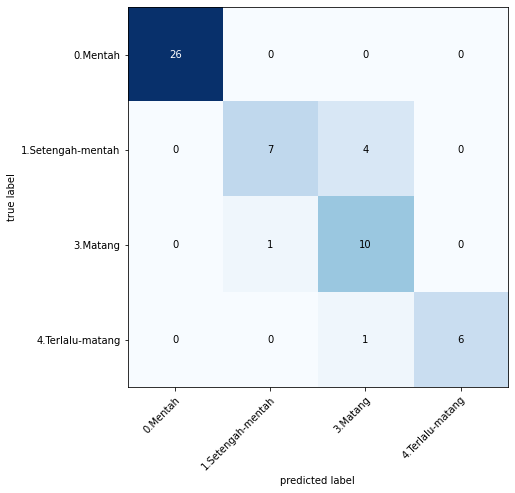

In [ ]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor, target=torch.Tensor(test_data.targets))

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy 
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 7)
);

#ViT-B/32

In [ ]:
# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_32_Weights.DEFAULT # requires torchvision >= 0.13, "DEFAULT" means best available

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_32(weights=pretrained_vit_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False
    
# 4. Change the classifier head (set the seeds to ensure same initialization with linear head)
set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)
# pretrained_vit # uncomment for model output 

Downloading: "https://download.pytorch.org/models/vit_b_32-d86f8d99.pth" to /root/.cache/torch/hub/checkpoints/vit_b_32-d86f8d99.pth


  0%|          | 0.00/337M [00:00<?, ?B/s]

In [ ]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [ ]:
# Setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=32) # Could increase if we had more samples, such as here: https://arxiv.org/abs/2205.01580 (there are other improvements there too...)


In [ ]:
from going_modular.going_modular import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(), 
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=100,
                                      device=device)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9644 | train_acc: 0.6946 | test_loss: 0.8300 | test_acc: 0.7792
Epoch: 2 | train_loss: 0.5423 | train_acc: 0.8372 | test_loss: 0.5756 | test_acc: 0.8444
Epoch: 3 | train_loss: 0.3969 | train_acc: 0.8668 | test_loss: 0.5122 | test_acc: 0.7792
Epoch: 4 | train_loss: 0.3398 | train_acc: 0.8856 | test_loss: 0.4287 | test_acc: 0.8879
Epoch: 5 | train_loss: 0.3023 | train_acc: 0.8980 | test_loss: 0.3834 | test_acc: 0.8818
Epoch: 6 | train_loss: 0.2765 | train_acc: 0.8986 | test_loss: 0.3564 | test_acc: 0.8818
Epoch: 7 | train_loss: 0.2444 | train_acc: 0.9211 | test_loss: 0.3283 | test_acc: 0.9035
Epoch: 8 | train_loss: 0.2354 | train_acc: 0.9251 | test_loss: 0.3199 | test_acc: 0.8818
Epoch: 9 | train_loss: 0.2098 | train_acc: 0.9342 | test_loss: 0.3246 | test_acc: 0.9096
Epoch: 10 | train_loss: 0.2061 | train_acc: 0.9209 | test_loss: 0.2913 | test_acc: 0.9035
Epoch: 11 | train_loss: 0.1934 | train_acc: 0.9415 | test_loss: 0.2884 | test_acc: 0.9035
Epoch: 12 | train_l

In [ ]:
import numpy as np
# Import tqdm for progress bar
from tqdm.auto import tqdm

# 1. Make predictions with trained model
y_preds = []
pretrained_vit.to(device)
pretrained_vit.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader_pretrained, desc="Making predictions"):
    # Send data and targets to target device
    X, y = X.to(device), y.to(device)
    # Do the forward pass
    y_logit = pretrained_vit(X)
    # Turn predictions from logits -> prediction probabilities -> predictions labels
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
    # Put predictions on CPU for evaluation
    y_preds.append(y_pred.cpu())
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)

Making predictions:   0%|          | 0/2 [00:00<?, ?it/s]

Exception ignored in: Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 235, in _feed
<function _ConnectionBase.__del__ at 0x7fd517642700>    
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 132, in __del__
close()
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 361, in _close
    self._close()
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 361, in _close
        _close(self._handle)
OSError: [Errno 9] Bad file descriptor
_close(self._handle)
OSError: [Errno 9] Bad file descriptor

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.8/threading.py", line 870, in run

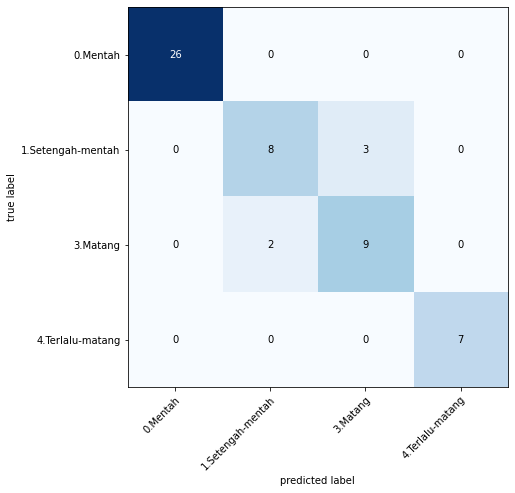

In [ ]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=torch.Tensor(test_data.targets))

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy 
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 7)
);

#ViT-L/16

In [ ]:
# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_L_16_Weights.DEFAULT # requires torchvision >= 0.13, "DEFAULT" means best available

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_l_16(weights=pretrained_vit_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False
    
# 4. Change the classifier head (set the seeds to ensure same initialization with linear head)
set_seeds()
pretrained_vit.heads = nn.Linear(in_features=1024, out_features=len(class_names)).to(device)
# pretrained_vit # uncomment for model output 

Downloading: "https://download.pytorch.org/models/vit_l_16-852ce7e3.pth" to /root/.cache/torch/hub/checkpoints/vit_l_16-852ce7e3.pth


  0%|          | 0.00/1.13G [00:00<?, ?B/s]

In [ ]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[242]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [ ]:
# Setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=32) # Could increase if we had more samples, such as here: https://arxiv.org/abs/2205.01580 (there are other improvements there too...)


In [ ]:
from going_modular.going_modular import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(), 
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=100,
                                      device=device)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9928 | train_acc: 0.7061 | test_loss: 0.7538 | test_acc: 0.7480
Epoch: 2 | train_loss: 0.6059 | train_acc: 0.8001 | test_loss: 0.5430 | test_acc: 0.8444
Epoch: 3 | train_loss: 0.4561 | train_acc: 0.8520 | test_loss: 0.5000 | test_acc: 0.7636
Epoch: 4 | train_loss: 0.3952 | train_acc: 0.8708 | test_loss: 0.4164 | test_acc: 0.8444
Epoch: 5 | train_loss: 0.3532 | train_acc: 0.8849 | test_loss: 0.3724 | test_acc: 0.8662
Epoch: 6 | train_loss: 0.3192 | train_acc: 0.9037 | test_loss: 0.3553 | test_acc: 0.8444
Epoch: 7 | train_loss: 0.2861 | train_acc: 0.9145 | test_loss: 0.3176 | test_acc: 0.8879
Epoch: 8 | train_loss: 0.2719 | train_acc: 0.9110 | test_loss: 0.3113 | test_acc: 0.8879
Epoch: 9 | train_loss: 0.2429 | train_acc: 0.9309 | test_loss: 0.3179 | test_acc: 0.8444
Epoch: 10 | train_loss: 0.2343 | train_acc: 0.9192 | test_loss: 0.2791 | test_acc: 0.8879
Epoch: 11 | train_loss: 0.2181 | train_acc: 0.9359 | test_loss: 0.2730 | test_acc: 0.8879
Epoch: 12 | train_l

In [ ]:
import numpy as np
# Import tqdm for progress bar
from tqdm.auto import tqdm

# 1. Make predictions with trained model
y_preds = []
pretrained_vit.to(device)
pretrained_vit.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader_pretrained, desc="Making predictions"):
    # Send data and targets to target device
    X, y = X.to(device), y.to(device)
    # Do the forward pass
    y_logit = pretrained_vit(X)
    # Turn predictions from logits -> prediction probabilities -> predictions labels
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
    # Put predictions on CPU for evaluation
    y_preds.append(y_pred.cpu())
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)

Making predictions:   0%|          | 0/2 [00:00<?, ?it/s]

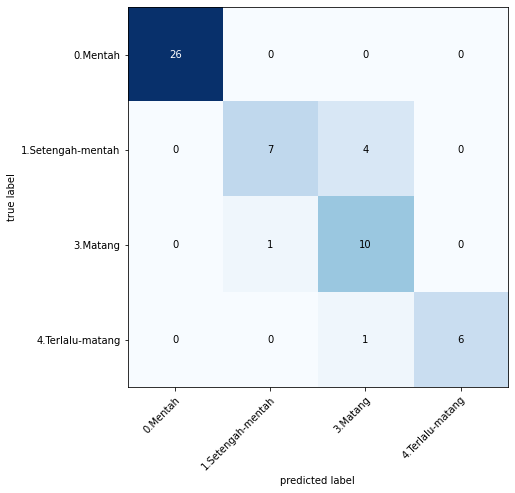

Exception ignored in: <function _ConnectionBase.__del__ at 0x7fd517642700>
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 132, in __del__
    self._close()
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor


In [ ]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=torch.Tensor(test_data.targets))

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy 
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 7)
);

#ViT-L/32

In [ ]:
# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_L_32_Weights.DEFAULT # requires torchvision >= 0.13, "DEFAULT" means best available

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_l_32(weights=pretrained_vit_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False
    
# 4. Change the classifier head (set the seeds to ensure same initialization with linear head)
set_seeds()
pretrained_vit.heads = nn.Linear(in_features=1024, out_features=len(class_names)).to(device)
# pretrained_vit # uncomment for model output 

Downloading: "https://download.pytorch.org/models/vit_l_32-c7638314.pth" to /root/.cache/torch/hub/checkpoints/vit_l_32-c7638314.pth


  0%|          | 0.00/1.14G [00:00<?, ?B/s]

In [ ]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [ ]:
# Setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=32) # Could increase if we had more samples, such as here: https://arxiv.org/abs/2205.01580 (there are other improvements there too...)


In [ ]:
from going_modular.going_modular import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(), 
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=100,
                                      device=device)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0575 | train_acc: 0.6535 | test_loss: 0.8363 | test_acc: 0.6827
Epoch: 2 | train_loss: 0.6402 | train_acc: 0.7853 | test_loss: 0.5576 | test_acc: 0.8662
Epoch: 3 | train_loss: 0.4824 | train_acc: 0.8536 | test_loss: 0.5041 | test_acc: 0.7480
Epoch: 4 | train_loss: 0.4058 | train_acc: 0.8757 | test_loss: 0.4078 | test_acc: 0.8879
Epoch: 5 | train_loss: 0.3559 | train_acc: 0.8931 | test_loss: 0.3551 | test_acc: 0.8879
Epoch: 6 | train_loss: 0.3241 | train_acc: 0.9044 | test_loss: 0.3409 | test_acc: 0.8879
Epoch: 7 | train_loss: 0.2856 | train_acc: 0.9145 | test_loss: 0.3079 | test_acc: 0.9096
Epoch: 8 | train_loss: 0.2742 | train_acc: 0.9143 | test_loss: 0.2979 | test_acc: 0.9096
Epoch: 9 | train_loss: 0.2448 | train_acc: 0.9375 | test_loss: 0.2997 | test_acc: 0.9096
Epoch: 10 | train_loss: 0.2379 | train_acc: 0.9209 | test_loss: 0.2601 | test_acc: 0.8879
Epoch: 11 | train_loss: 0.2214 | train_acc: 0.9490 | test_loss: 0.2628 | test_acc: 0.9096
Epoch: 12 | train_l

In [ ]:
import numpy as np
# Import tqdm for progress bar
from tqdm.auto import tqdm

# 1. Make predictions with trained model
y_preds = []
pretrained_vit.to(device)
pretrained_vit.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader_pretrained, desc="Making predictions"):
    # Send data and targets to target device
    X, y = X.to(device), y.to(device)
    # Do the forward pass
    y_logit = pretrained_vit(X)
    # Turn predictions from logits -> prediction probabilities -> predictions labels
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
    # Put predictions on CPU for evaluation
    y_preds.append(y_pred.cpu())
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)

Making predictions:   0%|          | 0/2 [00:00<?, ?it/s]

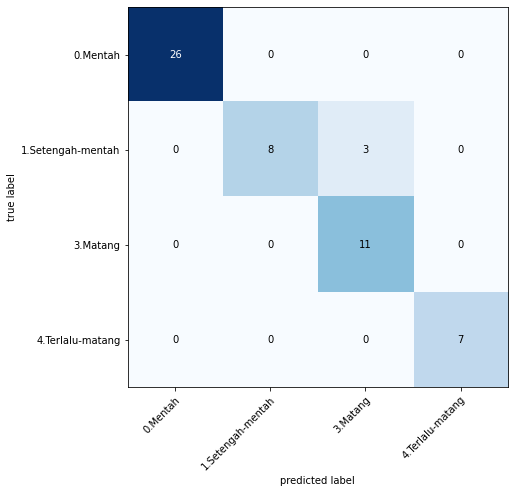

In [ ]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=torch.Tensor(test_data.targets))

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy 
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 7)
);

#ViT-H/14

In [ ]:
# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_H_14_Weights.DEFAULT # requires torchvision >= 0.13, "DEFAULT" means best available

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_h_14(weights=pretrained_vit_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False
    
# 4. Change the classifier head (set the seeds to ensure same initialization with linear head)
set_seeds()
pretrained_vit.heads = nn.Linear(in_features=1280, out_features=len(class_names)).to(device)
# pretrained_vit # uncomment for model output 

Downloading: "https://download.pytorch.org/models/vit_h_14_swag-80465313.pth" to /root/.cache/torch/hub/checkpoints/vit_h_14_swag-80465313.pth


  0%|          | 0.00/2.36G [00:00<?, ?B/s]

In [ ]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[518]
    resize_size=[518]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)


In [ ]:
# Setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=32) # Could increase if we had more samples, such as here: https://arxiv.org/abs/2205.01580 (there are other improvements there too...)


In [ ]:
import gc

from going_modular.going_modular import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(), 
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=100,
                                      device=device)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.4004 | train_acc: 0.8403 | test_loss: 0.3178 | test_acc: 0.8662
Epoch: 2 | train_loss: 0.2699 | train_acc: 0.8964 | test_loss: 0.2379 | test_acc: 0.9035
Epoch: 3 | train_loss: 0.2208 | train_acc: 0.8997 | test_loss: 0.2133 | test_acc: 0.9409
Epoch: 4 | train_loss: 0.2197 | train_acc: 0.9037 | test_loss: 0.2251 | test_acc: 0.9096
Epoch: 5 | train_loss: 0.1827 | train_acc: 0.9243 | test_loss: 0.1965 | test_acc: 0.9409
Epoch: 6 | train_loss: 0.1780 | train_acc: 0.9274 | test_loss: 0.2057 | test_acc: 0.9096
Epoch: 7 | train_loss: 0.1560 | train_acc: 0.9441 | test_loss: 0.1921 | test_acc: 0.9096
Epoch: 8 | train_loss: 0.1568 | train_acc: 0.9399 | test_loss: 0.1800 | test_acc: 0.9096
Epoch: 9 | train_loss: 0.1358 | train_acc: 0.9539 | test_loss: 0.2018 | test_acc: 0.9096
Epoch: 10 | train_loss: 0.1385 | train_acc: 0.9490 | test_loss: 0.1765 | test_acc: 0.9096
Epoch: 11 | train_loss: 0.1310 | train_acc: 0.9481 | test_loss: 0.1700 | test_acc: 0.9035
Epoch: 12 | train_l

In [ ]:
import numpy as np
# Import tqdm for progress bar
from tqdm.auto import tqdm

# 1. Make predictions with trained model
y_preds = []
pretrained_vit.to(device)
pretrained_vit.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader_pretrained, desc="Making predictions"):
    # Send data and targets to target device
    X, y = X.to(device), y.to(device)
    # Do the forward pass
    y_logit = pretrained_vit(X)
    # Turn predictions from logits -> prediction probabilities -> predictions labels
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
    # Put predictions on CPU for evaluation
    y_preds.append(y_pred.cpu())
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)

Making predictions:   0%|          | 0/2 [00:00<?, ?it/s]

Exception ignored in: <function _ConnectionBase.__del__ at 0x7fd517642700>
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 132, in __del__
    self._close()
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor


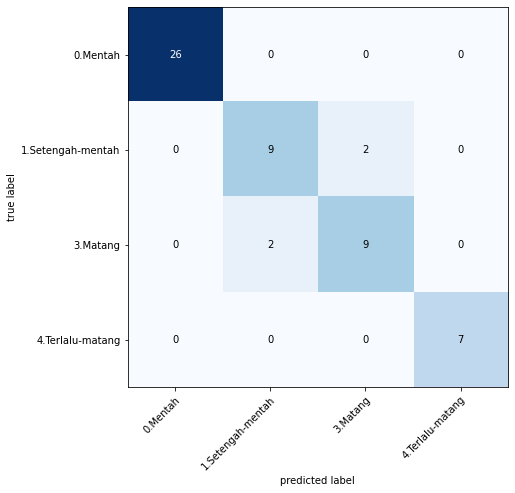

In [ ]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=torch.Tensor(test_data.targets))

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy 
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 7)
);

#VGG16

In [ ]:
# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.VGG16_Weights.DEFAULT  # requires torchvision >= 0.13, "DEFAULT" means best available

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vgg16(weights=pretrained_vit_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False
    
# 4. Change the classifier head (set the seeds to ensure same initialization with linear head)
n_inputs = pretrained_vit.classifier[6].in_features

pretrained_vit.classifier[6] = nn.Sequential(
    nn.Linear(n_inputs, 1000), nn.ReLU(), nn.Dropout(0.5),
    nn.Linear(1000, len(class_names)), nn.LogSoftmax(dim=1))

pretrained_vit.classifier
# pretrained_vit # uncomment for model output 

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Sequential(
    (0): Linear(in_features=4096, out_features=1000, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=1000, out_features=4, bias=True)
    (4): LogSoftmax(dim=1)
  )
)

In [ ]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [ ]:
# Setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=4) # Could increase if we had more samples, such as here: https://arxiv.org/abs/2205.01580 (there are other improvements there too...)


In [ ]:
from going_modular.going_modular import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(), 
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=100,
                                      device=device)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9212 | train_acc: 0.7279 | test_loss: 0.5200 | test_acc: 0.7857
Epoch: 2 | train_loss: 0.7096 | train_acc: 0.7738 | test_loss: 0.4181 | test_acc: 0.7976
Epoch: 3 | train_loss: 0.4867 | train_acc: 0.8469 | test_loss: 0.2452 | test_acc: 0.8571
Epoch: 4 | train_loss: 0.4413 | train_acc: 0.8333 | test_loss: 0.2847 | test_acc: 0.8750
Epoch: 5 | train_loss: 0.4109 | train_acc: 0.8452 | test_loss: 0.2983 | test_acc: 0.8393
Epoch: 6 | train_loss: 0.4628 | train_acc: 0.8367 | test_loss: 0.3618 | test_acc: 0.8036
Epoch: 7 | train_loss: 0.3359 | train_acc: 0.8673 | test_loss: 0.2459 | test_acc: 0.8929
Epoch: 8 | train_loss: 0.3766 | train_acc: 0.8384 | test_loss: 0.3174 | test_acc: 0.8214
Epoch: 9 | train_loss: 0.3624 | train_acc: 0.8537 | test_loss: 0.1941 | test_acc: 0.9464
Epoch: 10 | train_loss: 0.3429 | train_acc: 0.8639 | test_loss: 0.1878 | test_acc: 0.9286
Epoch: 11 | train_loss: 0.3636 | train_acc: 0.8639 | test_loss: 0.2153 | test_acc: 0.8929
Epoch: 12 | train_l

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd514d5de50>
Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fd514d5de50>
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
Exception ignored in: Exception ignored in: Exception ignored in: Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd514d5de50>    Traceback (most recent call last):

<function _MultiProcessingDataLoaderIter.__del__ at 0x7fd514d5de50>self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x7fd514d5de50>
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fd514d5de50><function _MultiProcessingDataLoaderIter.__del__ at 0x7fd514d5de50>
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fd514d5de50>Traceback (most recent call last):


Traceback (most recent call last):
Traceback (

Epoch: 71 | train_loss: 0.2541 | train_acc: 0.9150 | test_loss: 0.1399 | test_acc: 0.9286
Epoch: 72 | train_loss: 0.1974 | train_acc: 0.9320 | test_loss: 0.1645 | test_acc: 0.9107
Epoch: 73 | train_loss: 0.2200 | train_acc: 0.9184 | test_loss: 0.3270 | test_acc: 0.8393
Epoch: 74 | train_loss: 0.2215 | train_acc: 0.9201 | test_loss: 0.2330 | test_acc: 0.8929
Epoch: 75 | train_loss: 0.2158 | train_acc: 0.9218 | test_loss: 0.1511 | test_acc: 0.9286
Epoch: 76 | train_loss: 0.2120 | train_acc: 0.9201 | test_loss: 0.1889 | test_acc: 0.9107


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd514d5de50>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd514d5de50>Exception ignored in: 
Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd514d5de50>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd514d5de50>

Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fd514d5

Epoch: 77 | train_loss: 0.2829 | train_acc: 0.9184 | test_loss: 0.1871 | test_acc: 0.9286
Epoch: 78 | train_loss: 0.2068 | train_acc: 0.9116 | test_loss: 0.3378 | test_acc: 0.8036
Epoch: 79 | train_loss: 0.2853 | train_acc: 0.9116 | test_loss: 0.1909 | test_acc: 0.9464
Epoch: 80 | train_loss: 0.2066 | train_acc: 0.9252 | test_loss: 0.2423 | test_acc: 0.9286
Epoch: 81 | train_loss: 0.2706 | train_acc: 0.8946 | test_loss: 0.1685 | test_acc: 0.9464
Epoch: 82 | train_loss: 0.2435 | train_acc: 0.9133 | test_loss: 0.2876 | test_acc: 0.8929


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd514d5de50>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd514d5de50><function _MultiProcessingDataLoaderIter.__del__ at 0x7fd514d5de50>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fd514d5de50>Traceback (most recent call last):

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd514d5d

Epoch: 83 | train_loss: 0.2140 | train_acc: 0.9286 | test_loss: 0.1909 | test_acc: 0.9107
Epoch: 84 | train_loss: 0.2124 | train_acc: 0.9031 | test_loss: 0.2526 | test_acc: 0.8929
Epoch: 85 | train_loss: 0.2422 | train_acc: 0.9184 | test_loss: 0.2835 | test_acc: 0.8750
Epoch: 86 | train_loss: 0.1926 | train_acc: 0.9320 | test_loss: 0.2122 | test_acc: 0.8929
Epoch: 87 | train_loss: 0.2376 | train_acc: 0.9252 | test_loss: 0.3627 | test_acc: 0.8571
Epoch: 88 | train_loss: 0.2432 | train_acc: 0.9099 | test_loss: 0.1747 | test_acc: 0.9464


Exception ignored in: Exception ignored in: Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd514d5de50>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd514d5de50><function _MultiProcessingDataLoaderIter.__del__ at 0x7fd514d5de50>

<function _MultiProcessingDataLoaderIter.__del__ at 0x7fd514d5de50><function _MultiProcessingDataLoaderIter.__del__ at 0x7fd514d5de50>
Traceback (most recent call last):

Traceback (most recent call last):
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fd514d5de50>Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", li

Epoch: 89 | train_loss: 0.2590 | train_acc: 0.8980 | test_loss: 0.2348 | test_acc: 0.8750
Epoch: 90 | train_loss: 0.2299 | train_acc: 0.9099 | test_loss: 0.1669 | test_acc: 0.9464
Epoch: 91 | train_loss: 0.2550 | train_acc: 0.9184 | test_loss: 0.1764 | test_acc: 0.9464
Epoch: 92 | train_loss: 0.2685 | train_acc: 0.9269 | test_loss: 0.2488 | test_acc: 0.9286
Epoch: 93 | train_loss: 0.2436 | train_acc: 0.9116 | test_loss: 0.1774 | test_acc: 0.8929
Epoch: 94 | train_loss: 0.2082 | train_acc: 0.9320 | test_loss: 0.2194 | test_acc: 0.9286


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd514d5de50>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: Exception ignored in: Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd514d5de50><function _MultiProcessingDataLoaderIter.__del__ at 0x7fd514d5de50>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd514d5de50><function _MultiProcessingDataLoaderIter.__del__ at 0x7fd514d5de50>

<functio

Epoch: 95 | train_loss: 0.2212 | train_acc: 0.9048 | test_loss: 0.2084 | test_acc: 0.8929
Epoch: 96 | train_loss: 0.2873 | train_acc: 0.9048 | test_loss: 0.1691 | test_acc: 0.9286
Epoch: 97 | train_loss: 0.2228 | train_acc: 0.9184 | test_loss: 0.1788 | test_acc: 0.9107
Epoch: 98 | train_loss: 0.2162 | train_acc: 0.9167 | test_loss: 0.1350 | test_acc: 0.9643
Epoch: 99 | train_loss: 0.2017 | train_acc: 0.9133 | test_loss: 0.2129 | test_acc: 0.8929
Epoch: 100 | train_loss: 0.1728 | train_acc: 0.9337 | test_loss: 0.1986 | test_acc: 0.9107


In [ ]:
import numpy as np
# Import tqdm for progress bar
from tqdm.auto import tqdm

# 1. Make predictions with trained model
y_preds = []
pretrained_vit.to(device)
pretrained_vit.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader_pretrained, desc="Making predictions"):
    # Send data and targets to target device
    X, y = X.to(device), y.to(device)
    # Do the forward pass
    y_logit = pretrained_vit(X)
    # Turn predictions from logits -> prediction probabilities -> predictions labels
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
    # Put predictions on CPU for evaluation
    y_preds.append(y_pred.cpu())
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)

Making predictions:   0%|          | 0/14 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd514d5de50>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    Exception ignored in: Exception ignored in: assert self._parent_pid == os.getpid(), 'can only test a child process'<function _MultiProcessingDataLoaderIter.__del__ at 0x7fd514d5de50><function _MultiProcessingDataLoaderIter.__del__ at 0x7fd514d5de50>


AssertionErrorTraceback (most recent call last):
Traceback (most recent call last):
:   File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466

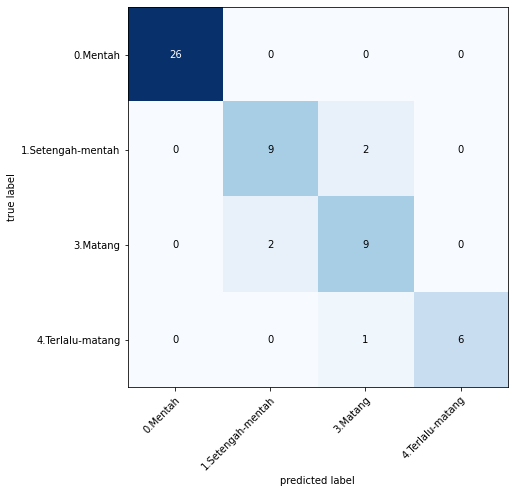

In [ ]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=torch.Tensor(test_data.targets))

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy 
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 7)
);

# VGG19

In [ ]:
# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.VGG19_Weights.DEFAULT  # requires torchvision >= 0.13, "DEFAULT" means best available

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vgg19(weights=pretrained_vit_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False
    
# 4. Change the classifier head (set the seeds to ensure same initialization with linear head)
n_inputs = pretrained_vit.classifier[6].in_features

pretrained_vit.classifier[6] = nn.Sequential(
    nn.Linear(n_inputs, 1000), nn.ReLU(), nn.Dropout(0.5),
    nn.Linear(1000, len(class_names)), nn.LogSoftmax(dim=1))

pretrained_vit.classifier
# pretrained_vit # uncomment for model output 

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Sequential(
    (0): Linear(in_features=4096, out_features=1000, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=1000, out_features=4, bias=True)
    (4): LogSoftmax(dim=1)
  )
)

In [ ]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [ ]:
# Setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=4) # Could increase if we had more samples, such as here: https://arxiv.org/abs/2205.01580 (there are other improvements there too...)


In [ ]:
from going_modular.going_modular import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(), 
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=100,
                                      device=device)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9335 | train_acc: 0.6956 | test_loss: 0.3737 | test_acc: 0.8214
Epoch: 2 | train_loss: 0.5963 | train_acc: 0.7993 | test_loss: 0.3051 | test_acc: 0.8214
Epoch: 3 | train_loss: 0.4738 | train_acc: 0.8367 | test_loss: 0.2371 | test_acc: 0.9107
Epoch: 4 | train_loss: 0.3594 | train_acc: 0.8452 | test_loss: 0.2505 | test_acc: 0.9048
Epoch: 5 | train_loss: 0.5118 | train_acc: 0.8163 | test_loss: 0.2055 | test_acc: 0.9107
Epoch: 6 | train_loss: 0.3657 | train_acc: 0.8571 | test_loss: 0.5928 | test_acc: 0.7679
Epoch: 7 | train_loss: 0.3857 | train_acc: 0.8469 | test_loss: 0.2155 | test_acc: 0.8750
Epoch: 8 | train_loss: 0.3347 | train_acc: 0.8656 | test_loss: 0.2272 | test_acc: 0.9107
Epoch: 9 | train_loss: 0.3553 | train_acc: 0.8639 | test_loss: 0.2121 | test_acc: 0.9107
Epoch: 10 | train_loss: 0.3941 | train_acc: 0.8503 | test_loss: 0.1870 | test_acc: 0.9286
Epoch: 11 | train_loss: 0.4161 | train_acc: 0.8435 | test_loss: 0.1677 | test_acc: 0.9286
Epoch: 12 | train_l

In [ ]:
import numpy as np
# Import tqdm for progress bar
from tqdm.auto import tqdm

# 1. Make predictions with trained model
y_preds = []
pretrained_vit.to(device)
pretrained_vit.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader_pretrained, desc="Making predictions"):
    # Send data and targets to target device
    X, y = X.to(device), y.to(device)
    # Do the forward pass
    y_logit = pretrained_vit(X)
    # Turn predictions from logits -> prediction probabilities -> predictions labels
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
    # Put predictions on CPU for evaluation
    y_preds.append(y_pred.cpu())
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)

Making predictions:   0%|          | 0/14 [00:00<?, ?it/s]

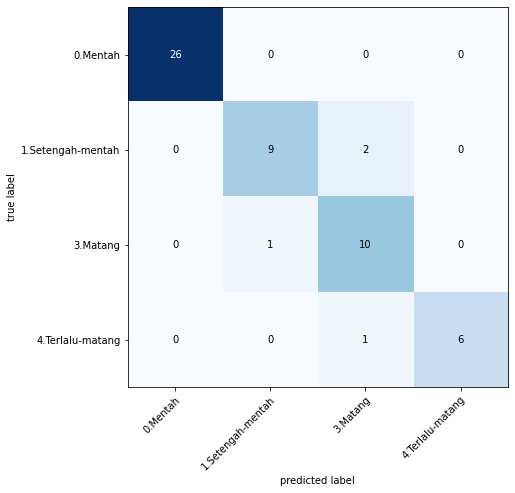

In [ ]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=torch.Tensor(test_data.targets))

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy 
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 7)
);